## Implementation of a CPPN in Tensorflow
The code is broken down in the following format. Each of the sub titles are described in detail above their respective cells. 

*   CPPN Initialization
*   Grid generation
*   Building the CPPN
*   Defining a fully connected network
*   Defining the activation functions
*   Running the CPPN
*   A sample CPPN call function

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## CPPN Initialization
This initialization function takes in the user provided parameters for an image of resolution **x_res** by **y_res**. The sub parameters involved work with deciding the following factors:
* Number of neurons in the neural net.
* Grayscale/RGB
* Random generator seed
* X, Y coordinate tensor dummies.
* Radius tensor.

In [ ]:
def CPPN_init(size, num_neurons, height, pos_x, pos_y, mag, RGB, seed, actfun = 1):

    global batch, net, hsize, xpos, ypos, scale, ch, img, hidden, x, y, r, num_points, random_seed, act_func
    batch = size
    net = num_neurons
    hsize = height
    xpos = pos_x
    ypos = pos_y
    scale = mag
    random_seed = seed
    act_func = actfun
    
    if RGB == True:
        ch = 3
    else:
        ch = 1

    num_points = pos_x * pos_y

    img = tf.random.normal(shape=(size, pos_x, pos_y, ch))
    hidden = tf.random.normal(shape=(size, height))
    x = tf.random.normal(shape=(size, pos_x * pos_y, 1))
    y = tf.random.normal(shape=(size, pos_x * pos_y, 1))
    r = tf.random.normal(shape=(size, pos_x * pos_y, 1))


## Grid generation
This section deals with generating a base set of tensors of the X,Y coordinates with respect to the scale assigned by the user. This is one of the prime features of the CPPN as it allows zooming into the pattern as desired. This also implements the radius math into the radius tensor. 

> **$r = \sqrt{x^{2}+y^{2}}$**

In [ ]:
def create_grid(pos_x, pos_y, mag):
    num_points = pos_x * pos_y

    x_space = tf.linspace(-1 * mag, mag, pos_x)
    y_space = tf.linspace(-1 * mag, mag, pos_y)
    x_mat = tf.matmul(tf.ones([pos_y, 1]), tf.reshape(x_space, [1, pos_x]))
    y_mat = tf.matmul(tf.reshape(y_space, [pos_y, 1]), tf.ones([1, pos_x]))
    r_mat = tf.math.sqrt(x_mat * x_mat + y_mat * y_mat)

    x_mat1 = tf.reshape(x_mat, [-1])
    x_mat = tf.reshape(x_mat1, [batch, num_points, 1])

    y_mat1 = tf.reshape(y_mat, [-1])
    y_mat = tf.reshape(y_mat1, [batch, num_points, 1])

    r_mat1 = tf.reshape(r_mat, [-1])
    r_mat = tf.reshape(r_mat1, [batch, num_points, 1])
    return x_mat, y_mat, r_mat

## Building the defined CPPN
This method is solely to generate the neural network layers and its activation functions. This implementation only provides with fully connected nets, but provides with an array of activation functions which can be called as required by the user. The fully connected net is generated with the assistance of the **dense()** function

**Insert Image here>**

In [ ]:
def build_CPPN(pos_x, pos_y, x, y, r, hidden):
    global network
    num_points = pos_x * pos_y

    hidden_mag = tf.reshape(hidden, [batch, 1, hsize]) * \
                     tf.ones([num_points, 1], dtype=np.float32) * scale

    unroll_x = tf.reshape(x, [batch * num_points, 1])
    unroll_y = tf.reshape(y, [batch * num_points, 1])
    unroll_r = tf.reshape(r, [batch * num_points, 1])
    unroll_h = tf.reshape(hidden_mag, [batch * num_points, hsize])

    network = dense(unroll_h, net) + \
                   dense(unroll_x, net, with_bias=False) + \
                   dense(unroll_y, net, with_bias=False) + \
                   dense(unroll_r, net, with_bias=False)

    
    if act_func == 1:
      out = tanh_sig()
      print('Activation in network tanh_sigmoid')
    elif act_func == 2:
      out = sin_tanh_sof()
      print('Activation in network sin_tanh_softmax')
    elif act_func == 3:
      out = tanh_sig_sin_sof()
      print('Activation in network tanh_sigmoid_sin_softmax')
    else:
      print('Invalid entry, defaulting back to 1: tanh_sigmoid')
      out = tanh_sig()
    model = np.reshape(out, (batch, pos_x, pos_y, ch))
    return model

def dense(input, out_dim, with_bias=True):
    mat = tf.random.normal(shape=(input.shape[1], out_dim))
    result = tf.matmul(input, mat)

    if with_bias == True:
        bias = tf.random.normal(shape=(1, out_dim))
        result += bias * tf.ones((input.shape[0], 1), dtype=tf.float32)

    return result

## The available activation functions.
* tanh_sigmoid
* sin_tanh_softmax
* tanh_sig_sin_softmax

In [ ]:
def tanh_sig(layers=3):
    z = tf.math.tanh(network)
    for i in range(layers):
        z = tf.math.tanh(dense(z, net))
    out = sigmoid(dense(z, ch))
    return out

def sin_tanh_sof():
    z = tf.math.tanh(network)
    z = 0.95 * tf.math.sin(dense(z, net))
    z = tf.math.tanh(dense(z, net))
    z = soft_plus(dense(z, net))
    z = tf.math.tanh(dense(z, net))
    out = soft_plus(dense(z, ch))
    return out    

def tanh_sig_sin_sof():
    z = tf.math.tanh(network)
    z = 0.8 * tf.math.sin(dense(z, net))
    z = tf.math.tanh(dense(z, net))
    z = soft_plus(dense(z, net))
    out = sigmoid(dense(z, ch))
    return out    

def sigmoid(x):
    sigmoid_x = 1.0 / (1 + tf.math.exp(-1 * x))
    return sigmoid_x


def soft_plus(x):
    return tf.math.log(1.0 + tf.math.exp(x))

# Runnning the CPPN
Once the CPPN is built, it is plotted with the help of the **matplotlib** library

In [ ]:
def run_CPPN(size, num_neurons, height, pos_x, pos_y, mag=10.0, RGB=True, seed=None, act_fun = 1):

    if seed is not None:
        tf.experimental.numpy.random.seed(0)

    
    CPPN_init(size, num_neurons, height, pos_x, pos_y, mag, RGB, seed, act_fun)

    if RGB == True:
        ch = 3
    else:
        ch = 1

    z = tf.random.uniform(shape=(batch, hsize), minval=-1.0, maxval=1.0, dtype=tf.float32)
    x, y, r = create_grid(pos_x, pos_y, mag)
    pattern = build_CPPN(pos_x, pos_y, x, y, r, z)
    plt.subplot(1, 1, 1)

    if RGB == False:
        plt.imshow(pattern.reshape(pos_y, pos_x), cmap='Greys', interpolation='nearest')
    else:
        plt.imshow(pattern.reshape(pos_y, pos_x, ch), interpolation='nearest')
    plt.axis('off')

    pattern = np.array(1 - pattern)

    if ch > 1:
        pattern = np.array(tf.reshape(pattern, [pos_y, pos_x, ch]) * 255.0, dtype=np.uint8)
    else:
        pattern = np.array(tf.reshape(pattern, [pos_y, pos_x]) * 255.0, dtype=np.uint8)

    im = Image.fromarray(pattern)
    im.save('CPPN.png')
    plt.show()

# Example run command
* Choose from act_fun = 1, 2 or 3 to switch between available activation functions.

> * 1 = tanh_sigmoid
> * 2 = sin_tanh_softmax
> * 3 = tanh_sigmoid_sin_softmax

* The output image will be saved as CPPN.png
________________________________________________________________________________


Activation in network tanh_sigmoid


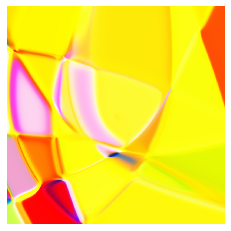

In [ ]:
run_CPPN(size = 1, num_neurons = 32, height = 32, pos_x = 1024, pos_y= 1024, mag = 10.0, RGB = True, seed = None, act_fun = 1)